In [30]:
# Imports for section 3 

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report

import skimage as ski
from pathlib import Path
from skimage.color import gray2rgb
import tensorflow as tf

keras = tf.keras
from sklearn.utils import shuffle
import keras
import random
# Set seeds for reproducibility
import random as python_random
np.random.seed(42)  # NumPy seed
python_random.seed(42)  # Python random seed
tf.random.set_seed(42) 

In [31]:
# additional_arguments(train_data_dir, test_data_dir, val_data_dir, rescale, shear_range, zoom_range, horizontal_flip)

def v_1_generate_images(_batch_size=32, _img_height=224, _img_width=224, ** kwargs):
    # Define the paths to your training and testing data
    train_data_dir = kwargs.get('train_data_dir', 'new_dataset_400/train')
    test_data_dir = kwargs.get('test_data_dir' , 'new_dataset_400/test')
    val_data_dir = kwargs.get('val_data_dir' , 'new_dataset_400/val')

    # Set up an ImageDataGenerator for preprocessing and data augmentation
    datagen = ImageDataGenerator(
        rescale= kwargs.get('rescale' , 1./255),        # Normalize pixel values to be between 0 and 1
        shear_range=kwargs.get('shear_range' , 0.2),        # Shear transformations
        zoom_range= kwargs.get('zoom_range',  0.2),         # Zoom transformations
        horizontal_flip=kwargs.get('horizontal_flip' , True)    # Horizontal flips
    )

 


    # Create a flow from the training data directory
    _train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(_img_height, _img_width),
        batch_size=_batch_size,
        class_mode='categorical' , # 'categorical' for multi-class classification,
        shuffle = True
    )

    _test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(_img_height, _img_width),
        batch_size=_batch_size,
        class_mode='categorical',
        shuffle = True
    )
    
    
    _val_generator = datagen.flow_from_directory(
        val_data_dir,
        target_size=(_img_height, _img_width),
        batch_size=_batch_size,
        class_mode='categorical',  
        shuffle = True
    )
    
   
    return _train_generator, _test_generator,_val_generator



In [32]:
# Set the batch size and image dimensions in 1 iteration 
v_1_batch_size = 32
v_1_img_height, v_1_img_width = 224, 224  # Adjust these dimensions based on my images


# generate_images(v_1_batch_size,_img_height=v_1_img_height, _img_width=v_1_img_width , rescale=1/255) 
# rescale = 1/255 -> normalize pixel values between 0-1
# shear_range = 0.2 -> generate images with different angles to help model identify objects  
# zoom_range =   0.2 -> generate images with different scales to make model more robust         
# horizontal_flip = True -> augment dataset by providing mirror images with different orientation


v_1_X_train, v_1_X_test,v_1_X_val = v_1_generate_images(v_1_batch_size,_img_height=v_1_img_height, _img_width=v_1_img_width , rescale=1/255 , shear_range= 0.2 , zoom_range=0.2, horizontal_flip=True)

Found 270 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [33]:
from pathlib import Path
def v_1_train_and_evaluate_model(learning_rate, train, test, val, _img_height=224, _img_width=224, epochs=200):
    """
    Build, train, and evaluate a convolutional neural network model.

    Parameters:
    learning_rate (float): Learning rate for the optimizer.
    train (Dataset): Training dataset.
    test (Dataset): Testing dataset.
    val (Dataset): Validation dataset.
    _img_height (int): Image height for the model input.
    _img_width (int): Image width for the model input.
    epochs (int): Number of epochs to train the model.
    

    Returns:
    tuple: Returns a tuple containing the model's training history, test accuracy, test loss, and the model itself.
    """

    # Define the model architecture
    v_1_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(_img_height, _img_width, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Add dropout to help prevent overfitting
        Dense(2, activation='softmax')  # Output layer for binary classification
    ])
    
    
    # Print a summary of the model to understand its architecture
    print('Summary of model:')
    v_1_model.summary()
    # Compile the model with Adam optimizer and binary crossentropy loss
    optimizer = Adam(learning_rate=learning_rate)
    v_1_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    # Setup early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)
    
    model_var = None
    
    if Path('./weights').is_dir() and   any(Path('./weights').iterdir()):
        v_1_model.load_weights('./weights/v_1_best_model.h5')
    else:
        # Train the model with the training data
        model_var = v_1_model.fit(train, epochs=epochs, validation_data=val,  callbacks=[early_stopping, reduce_lr])
        v_1_model.save_weights('./weights/v_1_best_model.h5')

    # Evaluate the trained model with the test data
    test_loss, test_acc = v_1_model.evaluate(test)
    print(f'Test accuracy with learning rate {learning_rate}: {test_acc}')

   
    
    # Return the training history, test accuracy, test loss, and the trained model
    return model_var, test_acc, test_loss, v_1_model


In [34]:
# Define a list of learning rates to try
v_1_learning_rates = [0.0001]


In [35]:
# Train and evaluate the model for different learning rates
v_1_results = {}
for lr in v_1_learning_rates:
    history, accuracy , loss,model  = v_1_train_and_evaluate_model(lr , v_1_X_train, v_1_X_test , v_1_X_val  ,v_1_img_height, v_1_img_width )
    v_1_results[lr] = {'accuracy' :accuracy,
                   'loss':loss,
                   'history':history,
                   'model':model}
        
   
    
    


Summary of model:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None,

In [36]:


def plot_results_for_model(hist, test_loss, test_acc, lr):
    """
    Plots the training history of a model, including loss and accuracy, and prints test results.

    Parameters:
    hist (History): The training history object returned by the fit method of a model.
    test_loss (float): The loss of the model on the test dataset.
    test_acc (float): The accuracy of the model on the test dataset.
    lr (float): The learning rate used in training the model.

    The function creates two subplots: one for the loss and one for the accuracy. It also prints
    out the learning rate, test accuracy, and test loss.
    """
    
    # Create a figure with two subplots horizontally aligned
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))

    # Divider line for better readability in console output
    print('---------------------------------------------------------\n' * 10)

    # Print learning rate, test accuracy, and test loss
    print('Learning rate:', lr)
    print('Test accuracy:', round(test_acc, 3), '%', 'Test loss:', round(test_loss, 3))

    # Plot training and validation loss
    ax[0].plot(hist.history['loss'], label='Model loss')
    ax[0].plot(hist.history['val_loss'], label='Val loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Calculate the number of epochs based on the accuracy history length
    epochs = len(hist.history['accuracy'])
    epochs_range = range(1, epochs + 1)

    # Plot training and validation accuracy
    ax[1].plot(epochs_range, hist.history['accuracy'][:epochs], label='Model accuracy')
    ax[1].plot(epochs_range, hist.history['val_accuracy'][:epochs], label='Val accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_ylim(0, 1)  # Set the y-axis limit to range from 0 to 1
    ax[1].legend()

    # Display the plot
    plt.show()


In [37]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report


def evaluate_performance(received_model):
    """
    Evaluates the performance of the provided model using a test dataset.

    Parameters:
    received_model: The trained model to be evaluated.

    This function uses a test dataset, processes it,
    and predicts outcomes using the provided model. It then displays a model's performance
    """
    
    # Initialize the test data generator with normalization
    test_datagen = ImageDataGenerator(rescale=1./255)

    # Setup the test data generator
    test_generator_eval = test_datagen.flow_from_directory(
        './new_dataset_400/test',  # Directory path to test dataset
        target_size=(224, 224),  # Target size of the images
        batch_size=32,  # Batch size
        class_mode='categorical',  # Class mode
        shuffle=False)  # Do not shuffle the data

    # Reset the generator to ensure we're evaluating on a consistent set of data#
    print(received_model.evaluate(test_generator_eval))
    
  
    print('---------------------------------------------------------\n' * 10)


In [38]:
import copy
def generate_results(model_results, eval_perf = True):
    highest_score = {}
    for model_lr, model_values in model_results.items():
        m_acc = model_values['accuracy']
        m_hist = model_values['history']
        m_loss = model_values['loss']
        model_obj = model_values['model']
       
        print(model_values)
        if m_acc > highest_score.get('accuracy',0):
            highest_score =model_values
            highest_score['lr'] = model_lr
        if m_hist:
            
            plot_results_for_model(m_hist ,m_loss ,m_acc , model_lr)
        if eval_perf:
            pass
            evaluate_performance(model_obj)
        
    return highest_score
            
    

In [39]:

# Print the results
print("Results:")
v_1_highest_score = generate_results(v_1_results)


Results:
{'accuracy': 0.9247311949729919, 'loss': 0.21217761933803558, 'history': None, 'model': <keras.engine.sequential.Sequential object at 0x0000026A9076C400>}
Found 93 images belonging to 2 classes.
3/3 [==============================] - 1s 509ms/step - loss: 0.1775 - accuracy: 0.9247
[0.17751049995422363, 0.9247311949729919]
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------
---------------------------------------------------------


## Show images which are incorrectly classified (Error Analysis)

In [40]:


def shuffle_images_and_labels(imgs, labels,file_names):
    """
    Shuffle images and their corresponding labels in unison.
    
    This function ensures that images and their labels are shuffled in the same way
    so that the relationship between each image and its label is maintained.
    
    Parameters:
    imgs (list or array): The list or array of images.
    labels (list or array): The list or array of labels corresponding to the images.
    
    Returns:
    tuple: A tuple containing two elements; the first is the shuffled images and
           the second is the shuffled labels.
    """
    
    # Convert the input lists to numpy arrays for efficient operations
    imgs, labels,file_names = np.array(imgs), np.array(labels), np.array(file_names)
    
    # Create an array of indices from 0 to the length of the images array
    indices = np.arange(0, len(imgs))
    
    # Shuffle the indices array in-place. This random permutation will be used
    # to shuffle both images and labels in the same order
    np.random.shuffle(indices)
    
    # Use the shuffled indices to reorder the images and labels arrays
    shuffled_imgs = imgs[indices]
    shuffled_labels = labels[indices]
    shuffled_file_names = file_names[indices]
    
    # Return the shuffled images and labels
    return shuffled_imgs, shuffled_labels,shuffled_file_names


In [41]:
def v_2_import_images_from_folder(folder_path: Path, target_size: tuple):
    """
    Imports images from a given folder, processes them, and assigns labels based on the folder name.
    
    This function reads images from two sub-folders within the specified path, assuming
    one folder contains images of one class and the other of another class. It resizes images,
    converts grayscale images to RGB, and ensures all images are in a consistent format. Labels
    are assigned based on the sub-folder name.
    
    Parameters:
    folder_path (Path): The path to the folder containing sub-folders of images.
    target_size (tuple): The desired size to which each image will be resized.
    
    Returns:
    tuple: A tuple containing two elements; the first is a list of processed images and
           the second is an array of labels corresponding to these images.
    """
    
    # Initialize class labels
    empty_class_label = [1, 0 ]
    full_class_label = [0,1]
    
    # Initialize a list to hold the paths of the class folders
    class_folders = []
    
    # Populate the list with paths to the class folders
    for class_folder in folder_path.iterdir():
        class_folders.append(class_folder)
        
    # Initialize lists to hold all images and their labels and their respective file names
    all_images = []
    all_labels = []
    all_file_names = []
    
    # Iterate over each class folder to process and label the images
    for class_folder in class_folders:
        # Extract the class folder name and convert it to lower case
        class_folder_name = str(class_folder).split('\\')[-1].lower()
        
        # Iterate over each image in the class folder
        for img_path in class_folder.iterdir():
            print(img_path)  # Print the path of the current image
            
            # Extract the file name from the image path
            file_name = str(img_path).split('\\')[-1]
            
            try:
                # Check the file extension to ensure it's a JPEG or JPG image
                file_extension = str(file_name).split('.')[-1]
                if file_extension != 'jpeg' and file_extension != 'jpg':
                    raise Exception(f'You can not have forbidden file extensions in dataset, this file is incorrect: {file_name}')
                
                # Read the image from the file
                img = ski.io.imread(str(img_path))
                
                # If the image is grayscale, convert it to RGB
                if len(img.shape) == 2:
                    img = gray2rgb(img)
                # If the image has more than 3 dimensions, raise an exception
                elif len(img.shape) > 3:
                    raise Exception(f'This image is not correct, it has more than 3 dimensions: {file_name}')
                
                # Resize the image to the target size
                image_resized = ski.transform.resize(img, target_size)
                # Convert the image to float format
                img = ski.util.img_as_float(image_resized)
                
                # Append the processed image to the list of all images
                all_images.append(img)
                # Assign and append the correct label based on the class folder name
                all_labels.append(empty_class_label if class_folder_name == 'empty_classroom' else full_class_label)
                all_file_names.append(str(img_path))
                
            except Exception as e:
                print(e)
                return
    
    # Shuffle the images and labels to randomize the order
    all_images, all_labels,all_file_names = shuffle_images_and_labels(all_images, all_labels , all_file_names)
    
    # Reshape the labels to ensure they are in the correct format
    all_labels = np.array(all_labels)
    
    # Return the list of processed images and their corresponding labels
    return all_images, all_labels,all_file_names


In [42]:


def v_1_generate_test_set(_img_height=224, _img_width=224, **kwargs):
    """
    Loads test dataset images and their labels from a specified directory.

    Parameters:
    _img_height (int): The target height of images after resizing.
    _img_width (int): The target width of images after resizing.
    **kwargs: Additional keyword arguments including 'test_data_dir' specifying
              the directory path of the test dataset.

    Returns:
    tuple: A tuple containing the test dataset images, their labels, and file names.
    """

    # Retrieve the test data directory path from keyword arguments or use the default path
    test_data_dir = Path(kwargs.get('test_data_dir', 'new_dataset_400/test'))

    # Use the specified function to import images and their labels from the directory
    test_data_set, test_labels_set, file_names = v_2_import_images_from_folder(test_data_dir, target_size=(_img_height, _img_width))

    # Return the loaded test dataset, labels, and file names for further processing or evaluation
    return test_data_set, test_labels_set, file_names




In [43]:
def v_1_generate_errors(received_model):
    """
    Identifies and returns images that were incorrectly classified by the provided model
    along with their file names. This function assumes the existence of a function named
    'v_1_generate_test_set' which loads the test dataset including the images, their labels,
    and the file names.

    Parameters:
    received_model: The trained model to be evaluated. This model is used to predict the labels of the test dataset.

    Returns:
    tuple: A tuple containing two elements. The first element is an array of images that were
    incorrectly classified. The second element is an array of file names corresponding to these images.
    """
    
    # Assuming v_1_generate_test_set is a function that generates or loads the test dataset
    # including the images, their corresponding labels, and file names
    test_data_set, test_labels_set, file_names = v_1_generate_test_set(v_1_img_height, v_1_img_width)
    
    # Use the provided model to predict the classes of the test dataset
    predictions = received_model.predict(test_data_set)
    
    # Convert predictions to binary (0 or 1) based on a threshold of 0.5
    predictions = (predictions > 0.5).astype('int')
    
    
     
    # # Identify the indices of images that were incorrectly classified
    mismatch_indices = list(set(np.where(predictions != test_labels_set)[0].tolist()))
    
    mismatch_indices.sort()
    
    print(mismatch_indices)
    # 
    # # Extract the file names of the incorrectly classified images using their indices
    mismatch_file_names = file_names[mismatch_indices]
    # 
    # # Similarly, extract the images that were incorrectly classified
    mismatch_images = test_data_set[mismatch_indices]
    # 
    # # Return the incorrectly classified images and their file names
    return mismatch_images, mismatch_file_names,test_labels_set[mismatch_indices]



In [44]:

def plot_class_mismatch(file_paths):
    """
    Plots a bar chart and a pie chart showing the number of mismatches for two classes: 'empty_class' and 'full_class'.
    
    Parameters:
    file_paths (list): A list of file paths for the images that were incorrectly classified.
    """
    
    # Initialize counters for each class mismatch
    empty_class_mismatch = 0
    full_class_mismatch = 0

    # Iterate through the provided file paths
    for file_path in file_paths:
        # Extract the filename from the file path
        file_name = str(file_path).split('\\')[-1].split('.')[0]
        
        # Count mismatches for 'empty_class' based on a naming convention
        if file_name.startswith('empty_classroom'):
            full_class_mismatch += 1
        else:
            # Assume any non-'empty_classroom' start is a 'full_class' mismatch
            empty_class_mismatch += 1
            
    # Plotting details for bar chart
    plt.figure(figsize=(14, 6))  # Set figure size for better visibility
    plt.subplot(1, 2, 1)  # Prepare subplot 1 in a 1x2 layout
    plt.title('Classes Mismatch - Bar Chart')  # Title of the bar chart
    plt.xlabel('Class Name')  # X-axis label
    plt.ylabel('Amount')  # Y-axis label
    plt.bar(['Empty Class', 'Full Class'], [empty_class_mismatch, full_class_mismatch])
    plt.axhline(y=len(file_paths), color='r', linestyle='--', label='Total Mismatches')
    plt.legend()

    # Plotting details for pie chart
    plt.subplot(1, 2, 2)  # Prepare subplot 2 in a 1x2 layout
    plt.title('Classes Mismatch - Pie Chart')  # Title of the pie chart
    sizes = [empty_class_mismatch, full_class_mismatch]  # Sizes for each slice
    labels = ['Empty Class', 'Full Class']  # Labels for each slice
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)  # Create pie chart
    plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

    # Display the plots
    plt.tight_layout()
    plt.show()



In [45]:


def v_1_plot_mismatched_images(mismatch_imgs, mismatch_file_paths):
    """
    Plots mismatched images side-by-side: the low-resolution version used by the model
    and the high-resolution original image.

    Parameters:
    mismatch_imgs (numpy.ndarray): An array of low-resolution images that were mismatched.
    mismatch_file_paths (list): A list of file paths to the original high-resolution images.
    """
    
    # Determine the number of mismatched images to plot
    imgs_num = mismatch_imgs.shape[0]

    # Assuming plot_class_mismatch is a function intended to display some form of analysis on the mismatches
    plot_class_mismatch(mismatch_file_paths)

    # Create a subplot grid with two columns for each mismatched image: one for low-res, one for high-res
    fig, axes = plt.subplots(imgs_num, 2, figsize=(20, 5*imgs_num))

    # Flatten the axes array for easy iteration, if there's more than one row of subplots
    axes = axes.flatten()

    imgs_idx = 0  # Index for iterating through mismatched images
    
    # Iterate through the axes array in steps of 2 to plot each pair of mismatched images
    for ax_idx in range(0, len(axes), 2):
        # Load the high-resolution image from its file path
        full_res_img = plt.imread(Path(mismatch_file_paths[imgs_idx]))
        
        # Display the low-resolution image (model's input) on the left
        axes[ax_idx].imshow(mismatch_imgs[imgs_idx])
        axes[ax_idx].axis('off')  # Turn off the axis to only display the image
        
        # Display the corresponding high-resolution image on the right
        axes[ax_idx + 1].imshow(full_res_img)
        axes[ax_idx + 1].axis('off')  # Turn off the axis here as well
        
        # Move to the next image in the list
        imgs_idx += 1
    
    # Show the plot containing all pairs of mismatched images
    plt.show()


In [46]:
v_1_mismatch_images,v_1_mismatch_file_names,v_1_mismatch_labels = v_1_generate_errors( v_1_highest_score['model'])


new_dataset_400\test\empty_classroom\empty_classroom_data1.jpeg
new_dataset_400\test\empty_classroom\empty_classroom_data103.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data104.jpeg
new_dataset_400\test\empty_classroom\empty_classroom_data105.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data118.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data119.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data121.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data123.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data13.jpeg
new_dataset_400\test\empty_classroom\empty_classroom_data133.jpeg
new_dataset_400\test\empty_classroom\empty_classroom_data134.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data143.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data148.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data149.jpg
new_dataset_400\test\empty_classroom\empty_classroom_data15.jpeg
new_dataset_400\test\emp

In [47]:
# v_1_mismatch_file_names

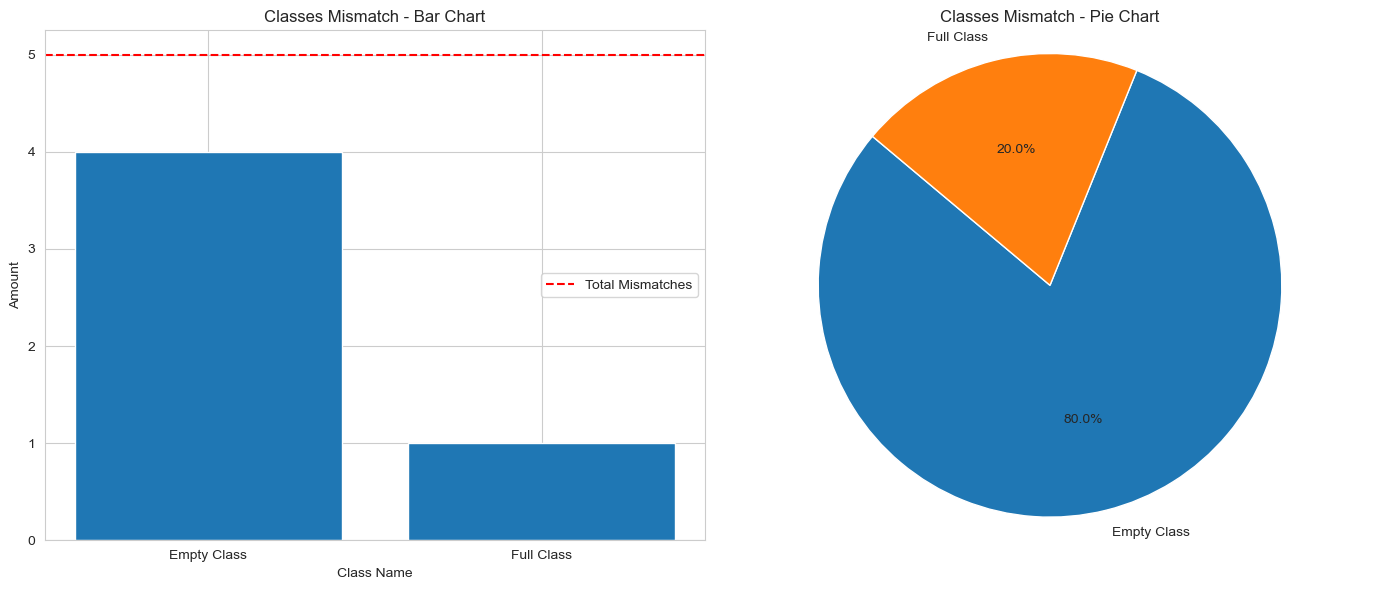

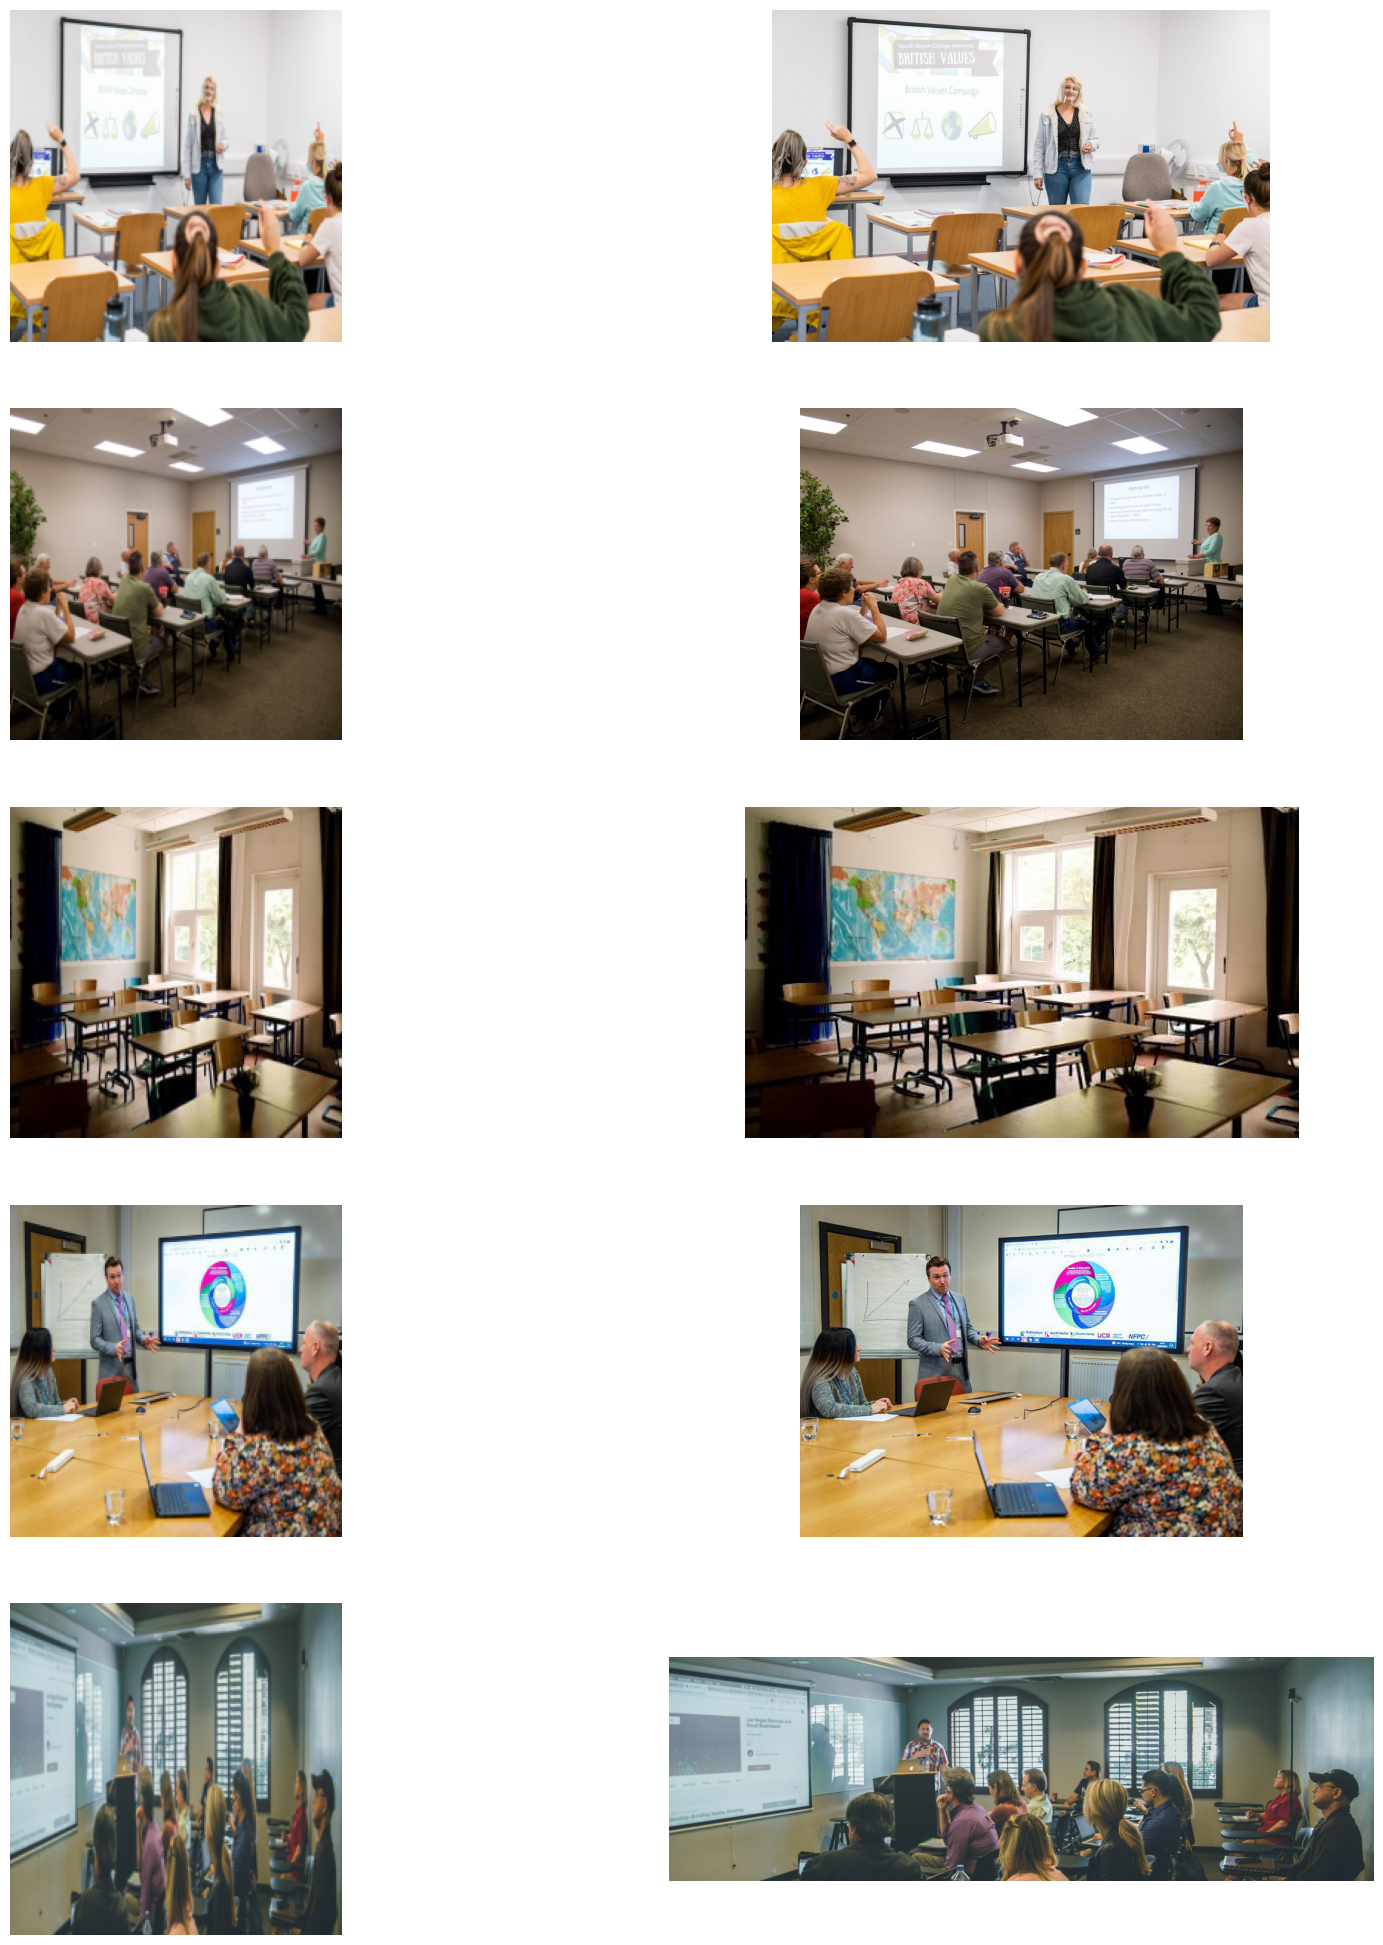

In [48]:
v_1_plot_mismatched_images(mismatch_imgs=v_1_mismatch_images, mismatch_file_paths=v_1_mismatch_file_names)

### Task 2.6

### In the context of your  classification model and task, which holds greater importance: achieving a high level of accuracy or ensuring interpretability? 

In the context of my classification model and task, achieving a high level of accuracy is more important due to the critical nature of the model's production environment, which necessitates precision and robust reliability to correctly identify classroom occupancy and provide real-time data. However, guaranteeing interpretability is critical, especially given potential biases discovered through error analysis. My model may be biased toward persons of color due to the minimal diversity of individuals in the dataset photos, and the absence of representation of people in wheelchairs may add to bias. As a result, analyzing the model's decision-making process is critical for ensuring AI justice to all persons. Despite the emphasis on accuracy, ensuring fairness and interpretability is critical, especially in high-risk contexts where the model may be used, such as stock exchanges with regular major conferences.

### Apply the selected XAI method(s) to your image classifier.

In [49]:
!pip install -U -q xplique

In [50]:
from itertools import product
from math import ceil
from time import time

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn import linear_model
from skimage.segmentation import quickshift, felzenszwalb, watershed, slic
from skimage.color import rgb2gray
from skimage.filters import sobel
from xplique.attributions import GradCAM, GradCAMPP

import xplique
from xplique.attributions import Lime, KernelShap
from xplique.plots import plot_attributions

In [51]:
# import image 
import skimage as ski

def import_and_resize_img(img_path:Path):
    initial_img = ski.util.img_as_float(ski.io.imread(img_path))
    
    resized_img = ski.transform.resize(initial_img, output_shape=(224,224,3))
    
    return initial_img , np.expand_dims(resized_img,0)
  
    



full_classroom_init_img , full_classroom_x = import_and_resize_img(Path('./full_classroom.jpeg'))
full_classroom_y  = np.array([[0., 1.]])

empty_classroom_init_img , empty_classroom_x = import_and_resize_img(Path('./empty_classroom.jpeg'))
empty_classroom_y = np.array([[1.,0.]])

In [52]:
print(f'Prediction :{v_1_highest_score["model"].predict(full_classroom_x)} Label: {full_classroom_y}')

print(f'Prediction :{v_1_highest_score["model"].predict(empty_classroom_x)} Label: {empty_classroom_y}')



1/1 [==============================] - 0s 34ms/step
Prediction :[[0.00658781 0.9934122 ]] Label: [[0. 1.]]
1/1 [==============================] - 0s 31ms/step
Prediction :[[0.947906   0.05209395]] Label: [[1. 0.]]


In [53]:
x_vals = [full_classroom_x, empty_classroom_x]
y_vals = [full_classroom_y , empty_classroom_y]
original_imgs = [full_classroom_init_img,empty_classroom_init_img]

### Run the XAI methods to generate explanations for the model's predictions.

In [54]:
model = v_1_highest_score['model']

Original image
---------------------------------------------
---------------------------------------------
Lime


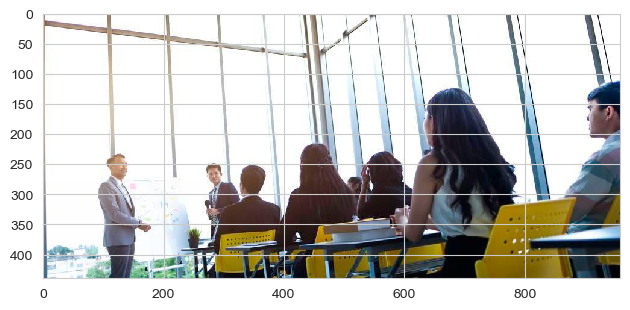

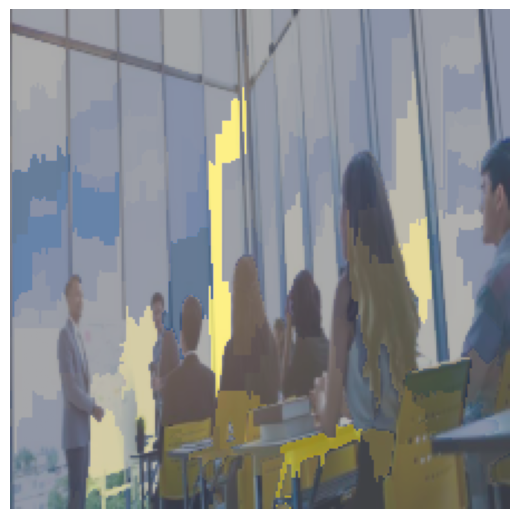

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------
Lime


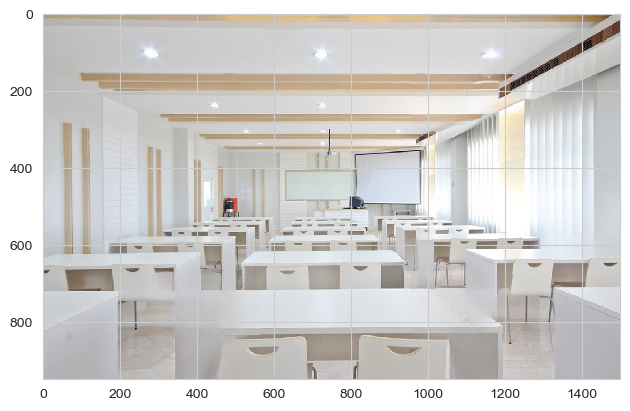

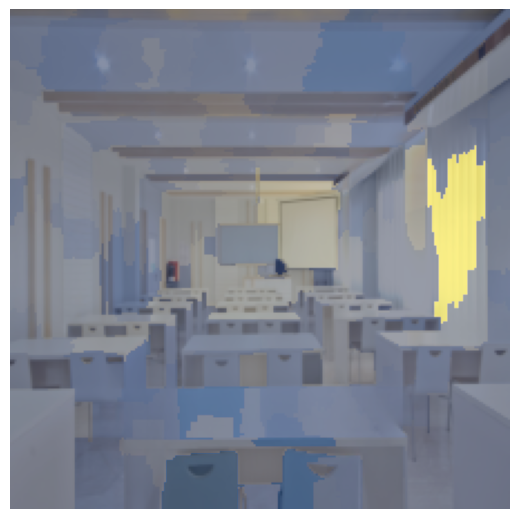

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------
KernelShap


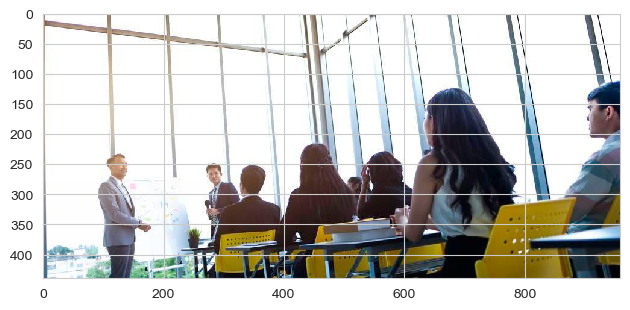

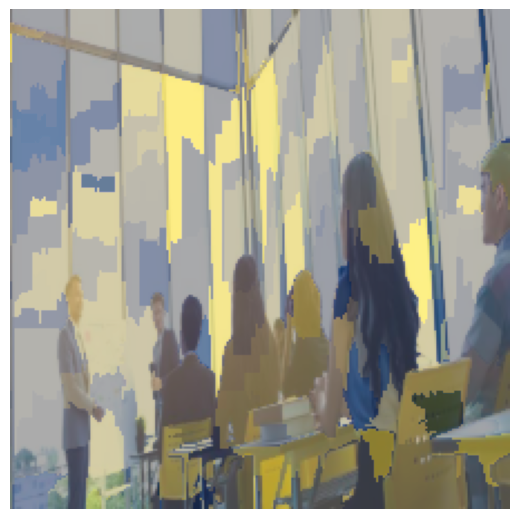

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------
KernelShap


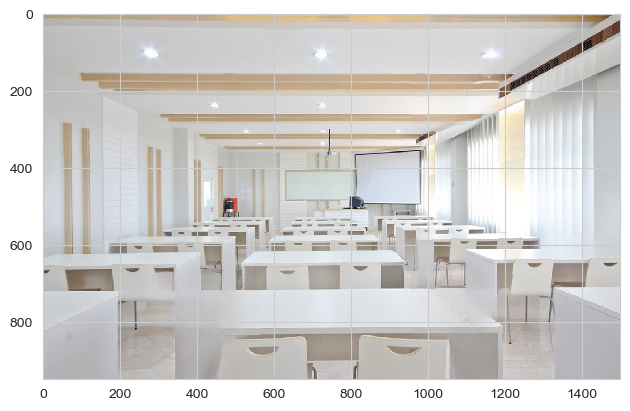

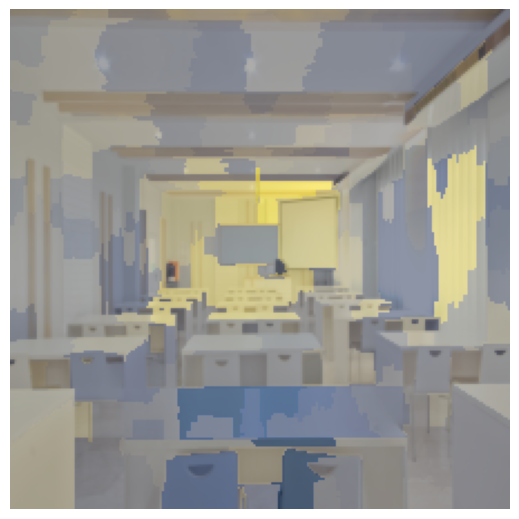

---------------------------------------------
---------------------------------------------


In [55]:
# define arbitrary parameters (common for all methods)
common_parameters = {
    "model": model,
    "batch_size": 16,
    "map_to_interpret_space": None,  # will use the default function
    "nb_samples": 4000,
    "ref_value": None,  # default value  will use (0.5, 0.5, 0.5) for images
}

lime_specific_parameters = {
    "interpretable_model": linear_model.Ridge(alpha=2),
    "similarity_kernel": None,  # will use the default function
    "pertub_func": None,  # will use the default function
    "distance_mode": "euclidean",  # default value
    "kernel_width": 45.0,  # default value adapted for 224x224 images
    "prob": 0.5,  # default value
}

# instanciate one explainer for each method
explainers = {
    "Lime": Lime(**common_parameters, **lime_specific_parameters),
    "KernelShap": KernelShap(**common_parameters),
}



# iterate on all methods
for method_name, explainer in explainers.items():
    # compute explanation by calling the explainer
    for x, y,original_img  in zip(x_vals, y_vals , original_imgs):
        print('Original image')
        ski.io.imshow(original_img)
        print('---------------------------------------------\n'*2)
        explanation = explainer.explain(x, y)
    
        # visualize explanation with plot_explanation() function
        print(method_name)
        plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
        plt.show()
        print('---------------------------------------------\n'*2)
    

### GradCam

Original image
---------------------------------------------
---------------------------------------------
GradCAM


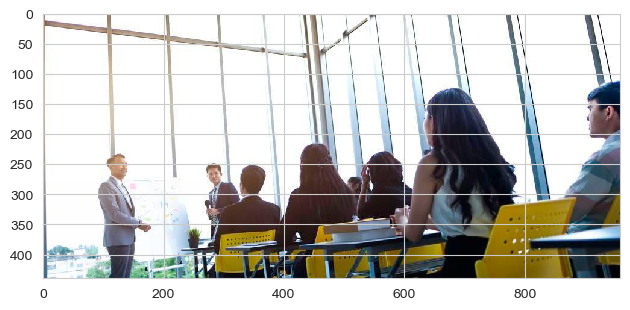

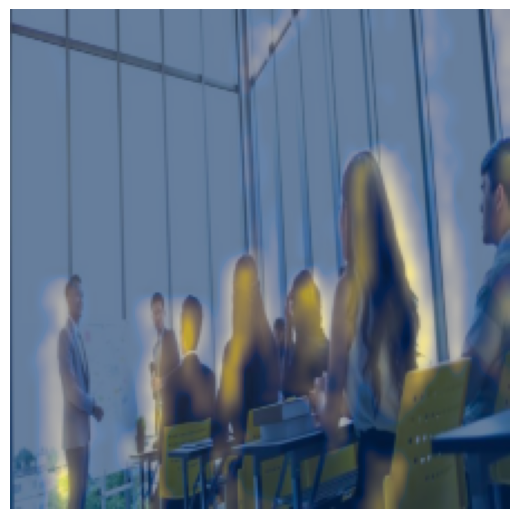

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------

GradCAM


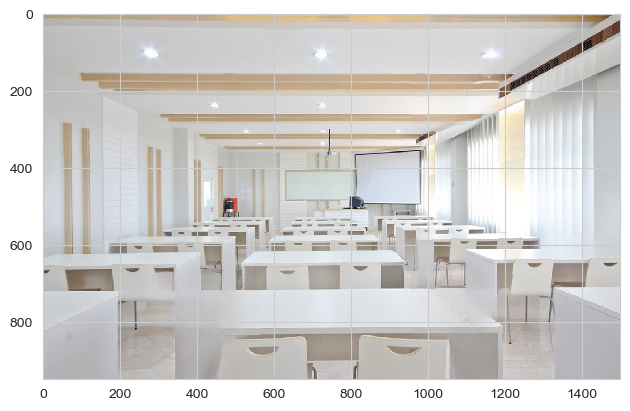

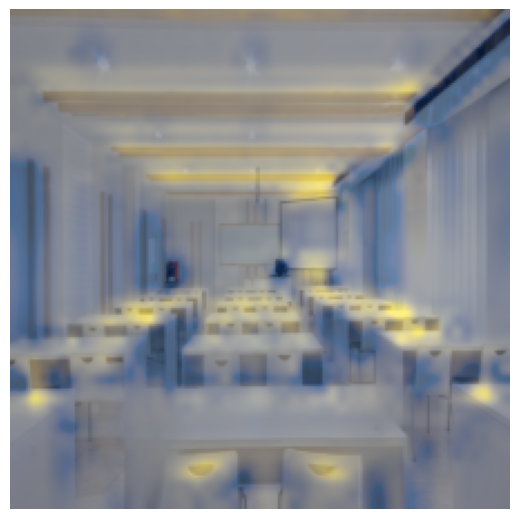

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------

GradCAMPP


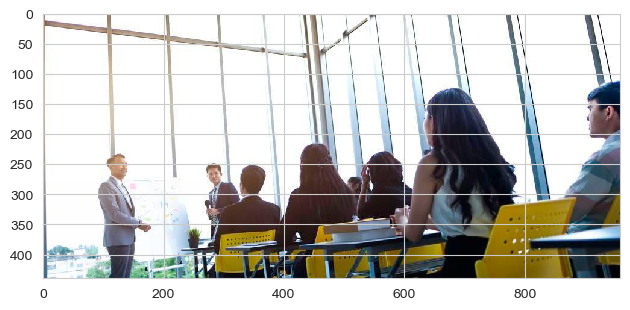

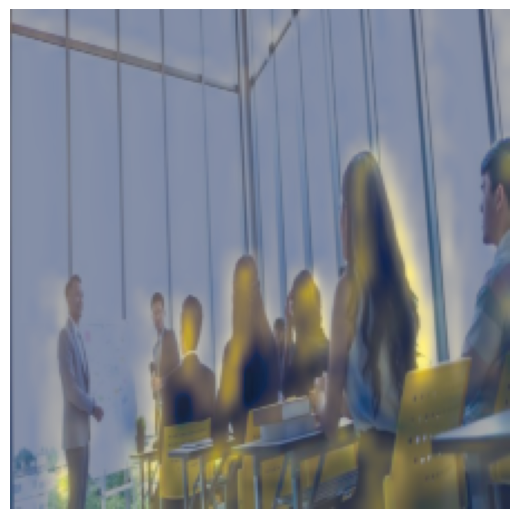

---------------------------------------------
---------------------------------------------

Original image
---------------------------------------------
---------------------------------------------

GradCAMPP


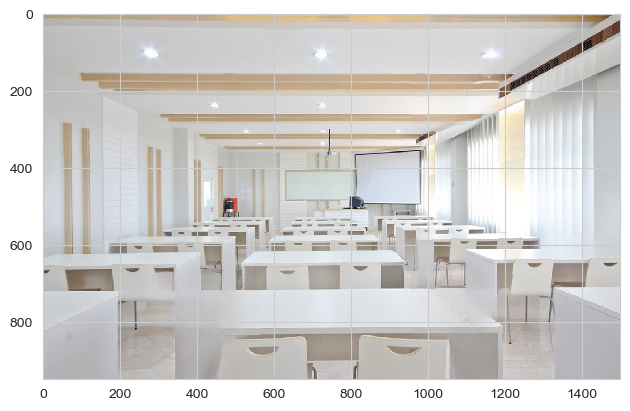

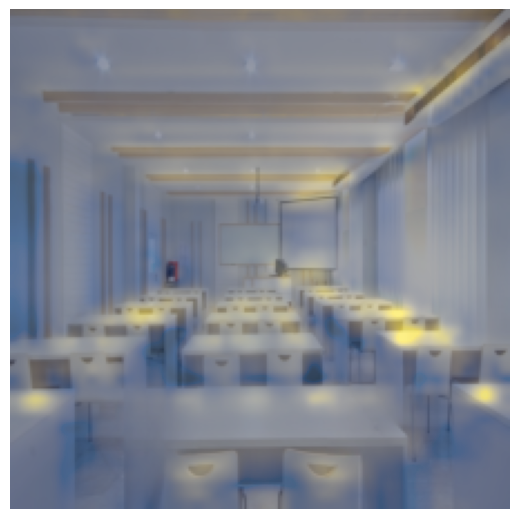

---------------------------------------------
---------------------------------------------


In [56]:
# define arbitrary parameters (common for all methods)
parameters = {
    "model": model,
    "output_layer": -2,
    "batch_size": 16,
    "conv_layer": None,
}

# instanciate one explainer for each method
explainers = {
    "GradCAM": GradCAM(**parameters),
    "GradCAMPP": GradCAMPP(**parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
   for x, y,original_img  in zip(x_vals, y_vals , original_imgs):
        print('Original image')
        ski.io.imshow(original_img)
        print('---------------------------------------------\n'*2)
        
        explanation = explainer.explain(x, y)
    
        # visualize explanation with plot_explanation() function
        print(method_name)
        plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
        plt.show()
        print('---------------------------------------------\n'*2)
    
    

    

### Look for patterns in the explanations that provide insights into how the model is making decisions.

- Grad-CAM's explanations have been quite informative. The heat maps produced by this approach revealed that my model continually focuses on human figures inside photos, favoring face characteristics and body outlines. This discernment in recognizing human presence as a significant factor of classroom occupancy highlights the model's sharp focus while also reaffirming its fit with the task's essential needs.

- Simultaneously, the model exhibits perceptive awareness that goes beyond what humans can discern. It examines classroom equipment, such as seats and tables, using their occupancy status as additional indicators of room emptiness. This delicate method, which balances the detection of human presence with the interpretation of space utilization, demonstrates the model's broad analytical capabilities. It demonstrates a sophisticated decision-making process that expertly navigates the complexity of the given job, demonstrating the model's ability not only to recognize figures but also to contextualize them within their surroundings.

### Analysis of misclassified images



In [57]:
# import image 
import skimage as ski

x_mis_vals = v_1_mismatch_images

y_mis_vals = v_1_mismatch_labels



### Grad-CAMP of Misclassified Images


[[0 1]]
Original image
---------------------------------------------
---------------------------------------------
GradCAMPP
1/1 [==============================] - 0s 33ms/step
True label: [[0 1]] Model prediction: [[0.86333734 0.1366626 ]]


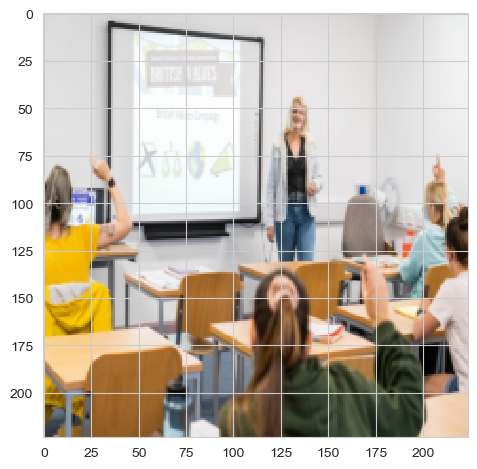

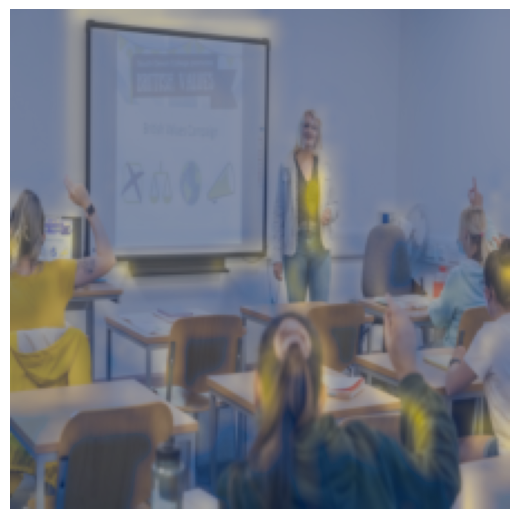

---------------------------------------------
---------------------------------------------

[[0 1]]
Original image
---------------------------------------------
---------------------------------------------

GradCAMPP
1/1 [==============================] - 0s 36ms/step
True label: [[0 1]] Model prediction: [[0.67055404 0.32944602]]


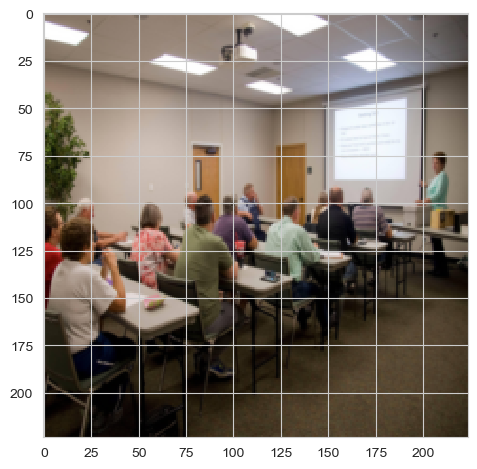

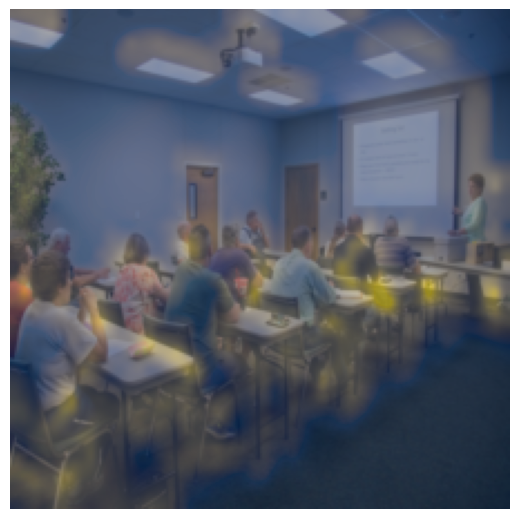

---------------------------------------------
---------------------------------------------

[[1 0]]
Original image
---------------------------------------------
---------------------------------------------

GradCAMPP
1/1 [==============================] - 0s 30ms/step
True label: [[1 0]] Model prediction: [[0.04668965 0.9533104 ]]


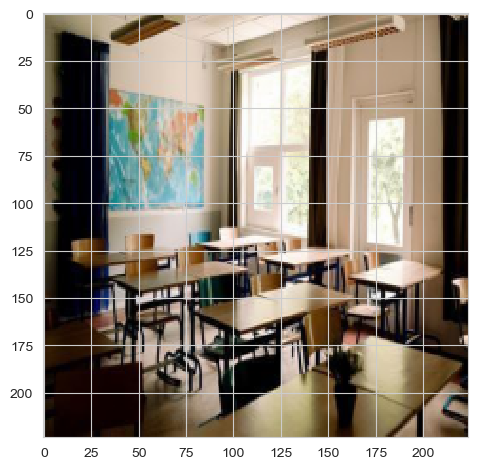

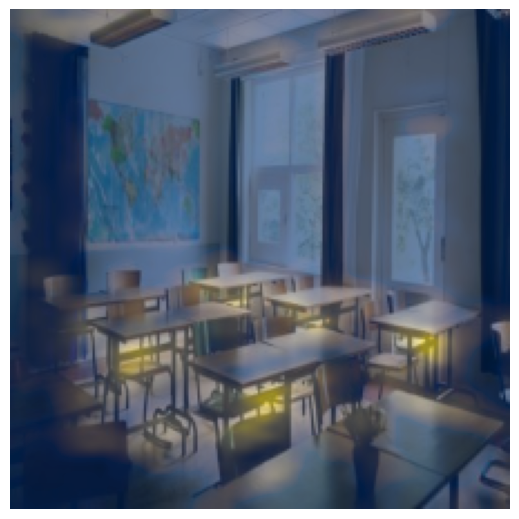

---------------------------------------------
---------------------------------------------

[[0 1]]
Original image
---------------------------------------------
---------------------------------------------

GradCAMPP
1/1 [==============================] - 0s 32ms/step
True label: [[0 1]] Model prediction: [[0.6540327  0.34596732]]


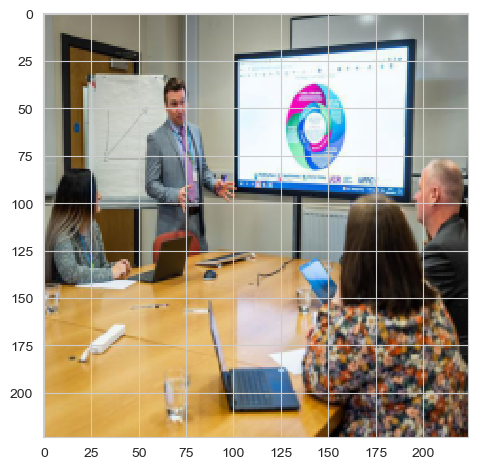

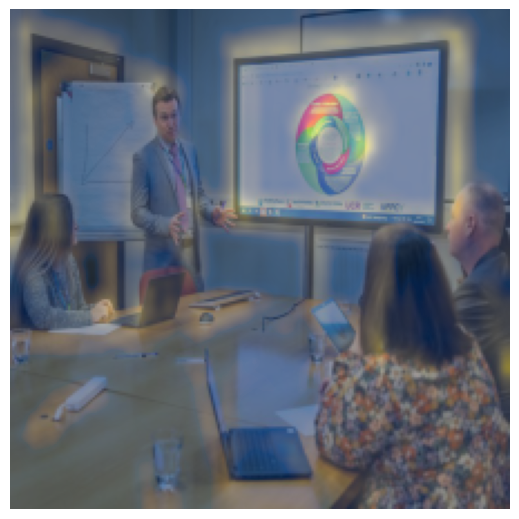

---------------------------------------------
---------------------------------------------

[[0 1]]
Original image
---------------------------------------------
---------------------------------------------

GradCAMPP
1/1 [==============================] - 0s 33ms/step
True label: [[0 1]] Model prediction: [[0.69802386 0.30197608]]


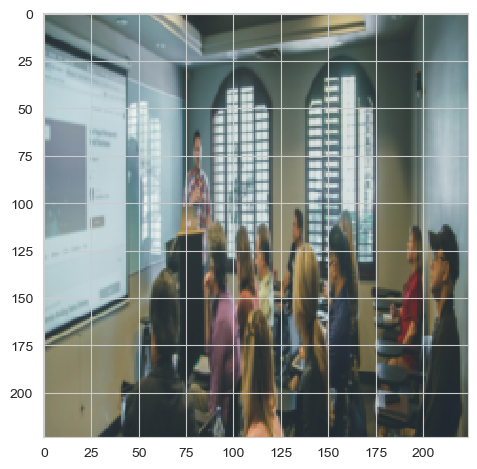

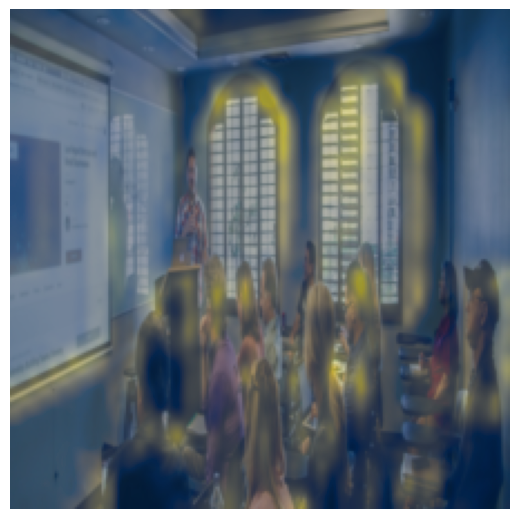

---------------------------------------------
---------------------------------------------


In [58]:
# define arbitrary parameters (common for all methods)
parameters = {
    "model": model,
    "output_layer": -2,
    "batch_size": 16,
    "conv_layer": None,
}

# instanciate one explainer for each method
explainers = {
    
    "GradCAMPP": GradCAMPP(**parameters),
}

# iterate on all methods
for method_name, explainer in explainers.items():
   for x, y,  in zip(x_mis_vals, y_mis_vals):
        
        x = np.expand_dims(x,0)
        y  = y.reshape(1,-1)
        
        print(y)
        
        print('Original image')
        ski.io.imshow(x[0])
        
        
        print('---------------------------------------------\n'*2)
            
        explanation = explainer.explain(x,y )
    
        # visualize explanation with plot_explanation() function
        print(method_name)
        print(f'True label: {y} Model prediction: {v_1_highest_score["model"].predict(x)}')
        plot_attributions(explanation, x, img_size=5, cmap='cividis', cols=1, alpha=0.6)
        plt.show()
        print('---------------------------------------------\n'*2)
    
    

    

### Conclusions
- During my investigation of the model's misclassifications, I discovered a repeating trend in which the model mistakenly concentrates on background items, such as chairs or boards, to decide if a classroom is empty. This demonstrates a fault in the model's thinking, since it occasionally fails to correctly detect human presence. For example, the model may recognize human beings in a photo but still suggest the classroom is empty, revealing a key flaw in its decision-making process.
- To improve interpretability and solve these challenges, I investigated a variety of explainable AI (XAI) techniques, including LIME, SHAP, and GradCAM. Grad-CAM, in particular, provided comprehensive visual explanations that highlighted the model's essential aspects. This was useful in illustrating that the model frequently emphasizes background factors over more important attributes.
- Grad-CAM not only helped achieve a balance between accuracy and interpretability, but it also identified possible biases in the model's decision-making process. For example, the model's overemphasis on certain items when forecasting classroom occupancy indicates a bias that may impair its dependability. This investigation of XAI approaches and their application to my model has been a beneficial exercise, increasing my knowledge of the model's behavior and driving modifications to guarantee its conclusions are both accurate and defensible.